In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [1]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
gpu_devices = [device.name for device in local_device_protos if device.device_type == 'GPU']
print(gpu_devices)

['/device:GPU:0']


1. Training set
    - Traing images are original and without "heavy" image processing
    - Imbalanced distribution
    - **Traditional features** from images
        - Local features : SIFT - kmeans (160) + HOG - PCA (160)
        - Texture features: Gabor (96) + LBPH (71)
        - Global (38) + GLCM (16)
2. CNN models
    - Use  full "Transfer Learning" approach with MobileNetV2:
        - Transfer learning 
        - Fine tune the whole CNN
    - Use **class weights in PT**
    - Use basic data augmentation from github module **'imgaug'**
        - Affine transform
            - Rotation: 0 to 270 degrees
            - Shear : +- 10 degrees
            - Zoom / scaling: +-20%
        - Horizontal and vertial flip
        - Gaussian Noise with stddev between 0 to 0.05 

In [2]:
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
    print("tensorflow - current version:", tf.__version__)
    print("tensorflow - physical device:", tf.config.list_physical_devices())
else:
    print("The installed version of TensorFlow does not include GPU support.")
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
tensorflow - current version: 2.10.0
tensorflow - physical device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import time
import datetime

from pathlib import Path
import pandas as pd


import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras import Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, LeakyReLU,ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Input ,concatenate
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.models import model_from_json
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from collections import Counter
from collections import OrderedDict
from itertools import cycle

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,  roc_curve, auc



import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.patches as mpatches

from PIL import Image

import random
import numpy as np
from numpy import where

import sys
import importlib.util

import gc
# mixed_precision.set_global_policy('float32')
# policy = mixed_precision.experimental.Policy('float32')
# mixed_precision.experimental.set_policy(policy)

# 1. Mount google drive to access the data and scripts

## 1.2. Unzip the zipped folder to a colab temporary drive

# 1. Load fold1 (training set + validation set) and test set

In [4]:
mycwd = os.getcwd()

display(mycwd)

'C:\\Users\\chevalier.c\\Documents\\GitHub\\_Plankton_Zooscan-Machine_Learning\\_pyscripts\\_transfer_learning'

In [5]:
os.chdir("..")
%pwd

'C:\\Users\\chevalier.c\\Documents\\GitHub\\_Plankton_Zooscan-Machine_Learning\\_pyscripts'

In [6]:
X_train_df = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')
X_validation_df = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv')

X_test_df = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [7]:
display(X_train_df.head(5), X_train_df.shape)
display(X_validation_df.head(5), X_validation_df.shape)
display(X_test_df.head(5), X_test_df.shape)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004.png,0


(44099, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0006-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,001-aggregates-jo_700_05.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0010-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0011.png,0


(14700, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0007-aggregates_002.png,0
1,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0009-aggregates_001.png,0
2,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0012-aggregates_002.png,0
3,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,002-aggregates_001.png,0
4,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,002-aggregates_007.png,0


(6907, 4)

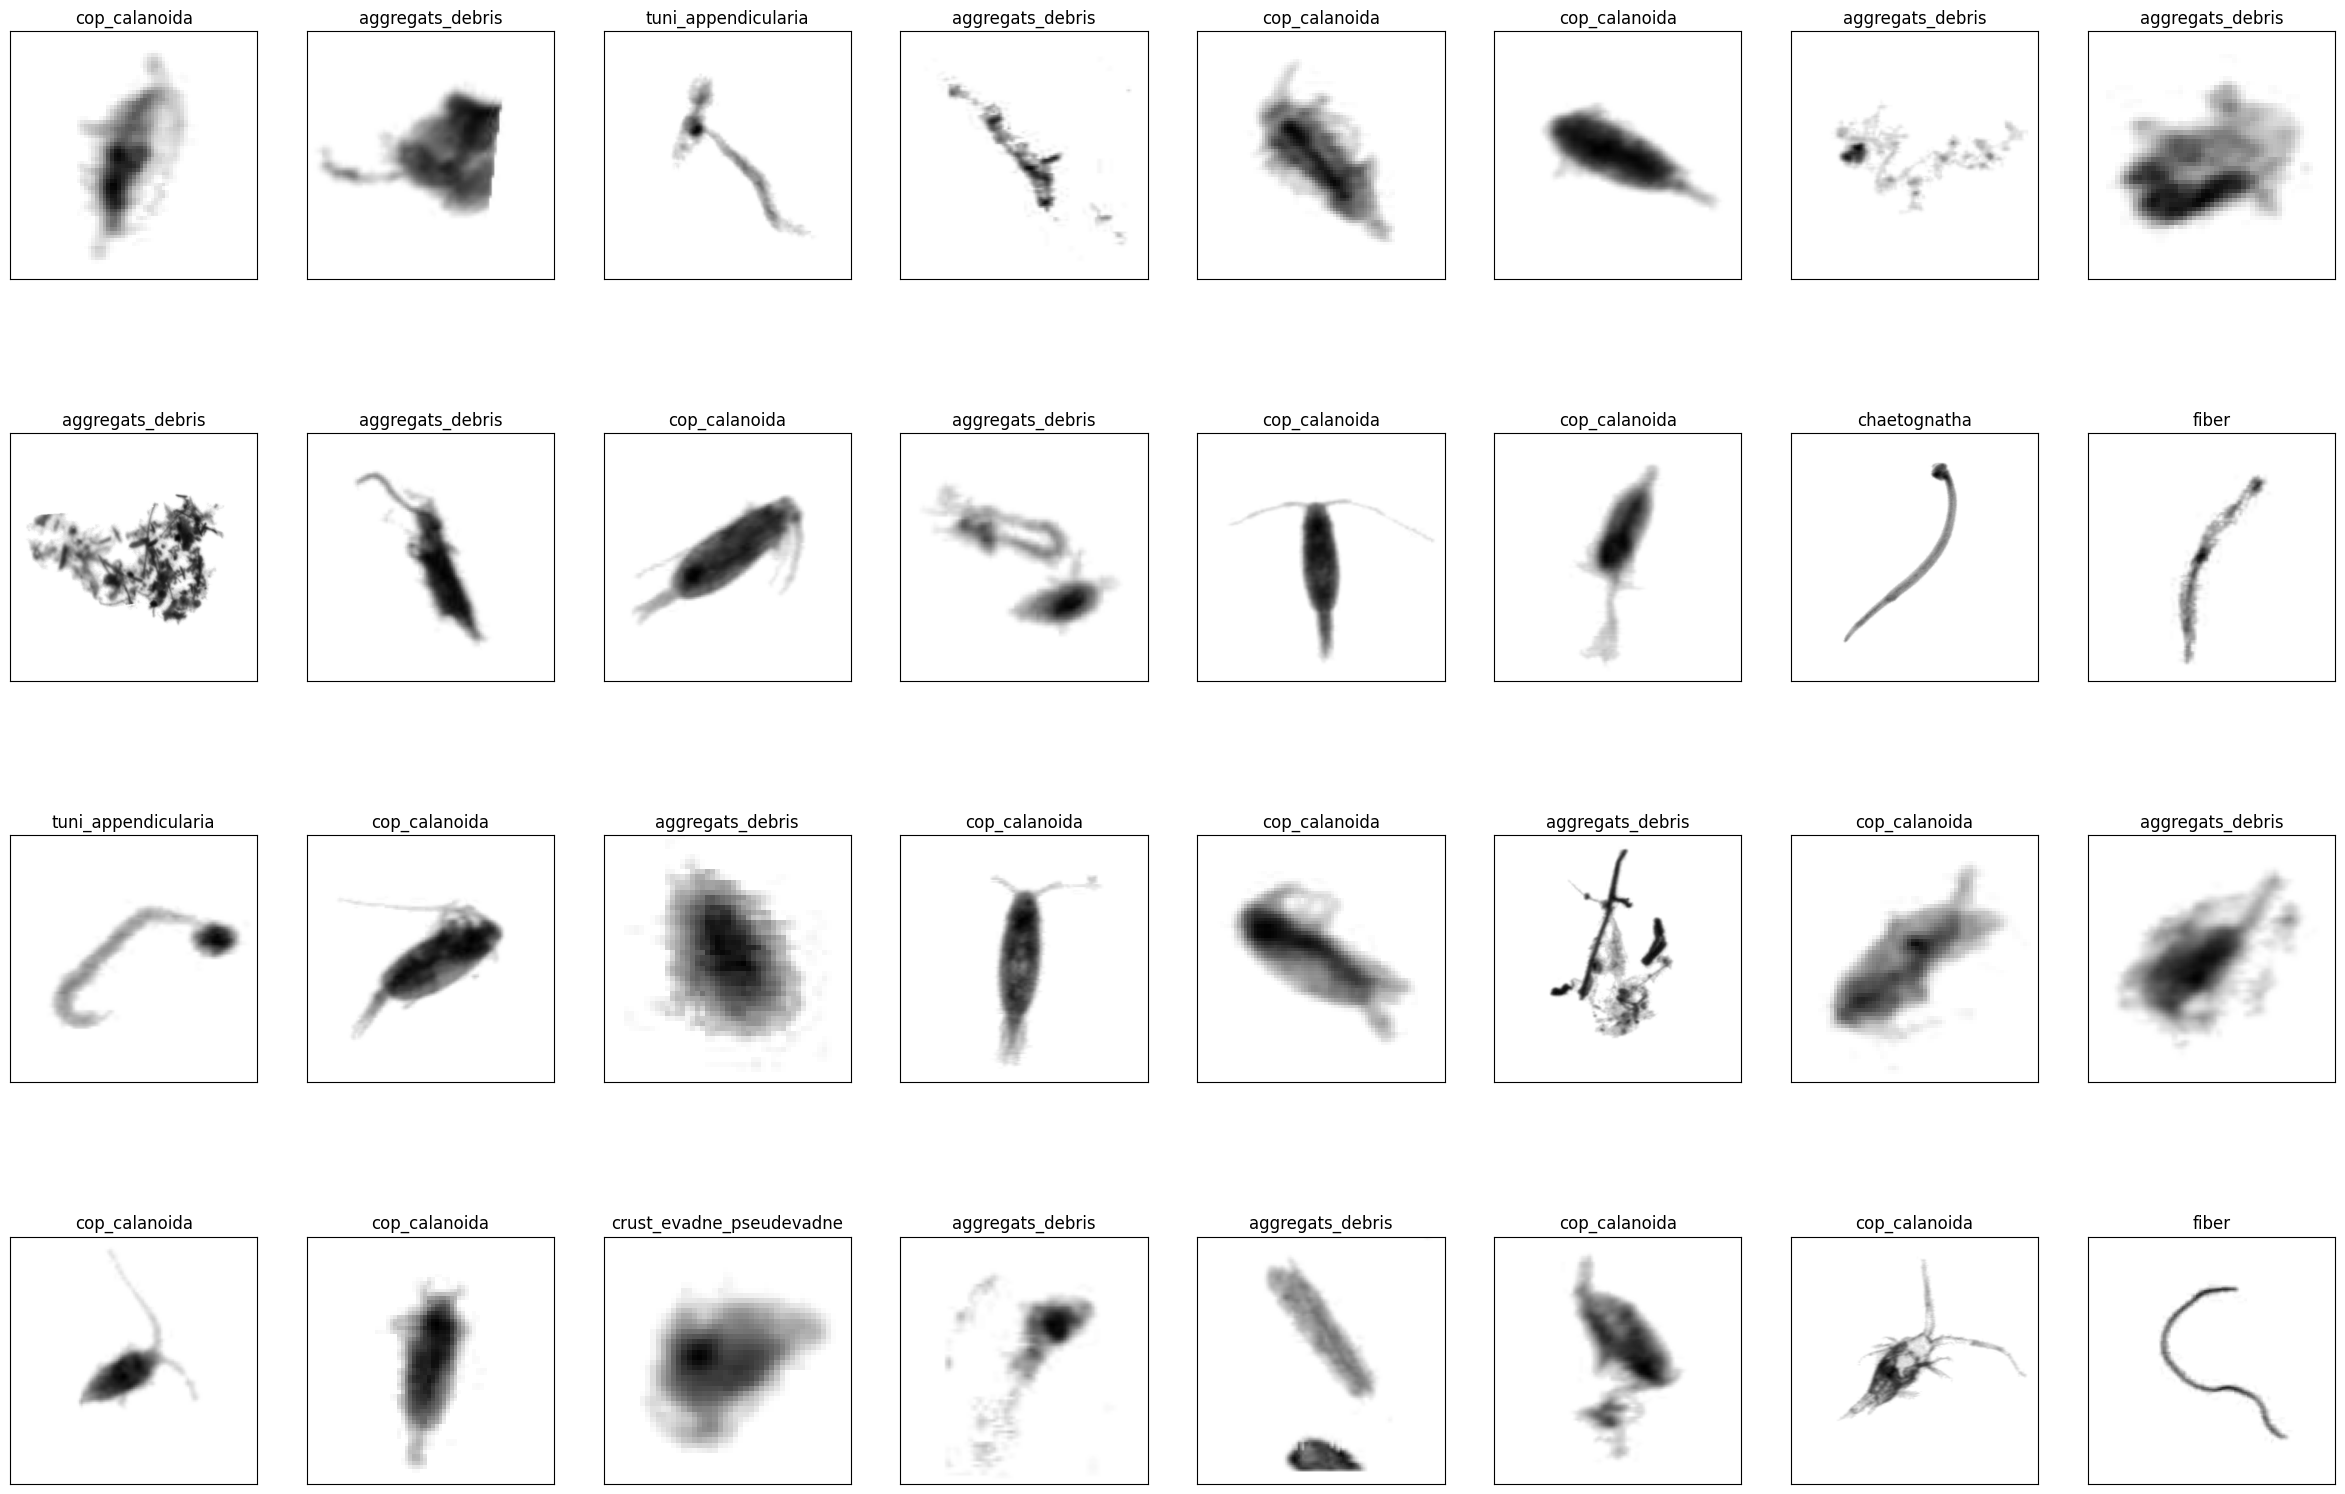

In [8]:
# show some random images in training set

plt.figure(figsize=(30, 20))
for i in range(32):
    row_df = X_train_df.sample()
    label = row_df['labels'].to_list()[0]
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(load_img(row_df['filenames'].to_list()[0], color_mode='rgb', interpolation="nearest"))
    ax.set_title(label)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

# 3. Data augmentation 


In [9]:
!pip install imgaug

In [10]:
import imgaug.augmenters as iaa
# import imgaug as ia

In [ ]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

image_augmentation = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        iaa.AdditiveGaussianNoise(scale=(0.00, 0.05)), # gaussian noise varies between 0.01 and 0.05*255
        sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    rotate=(0, 270), # rotate by 0 to +270 degrees
                    shear=(-10, 10), # shear by -10 to +10 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    # cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode="reflect" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
    ],
    random_order=True
)

# 4. Fold 1 data configuration

In [ ]:
from tensorflow.data import AUTOTUNE

BATCH_SIZE = 32

In [ ]:
def load_images(imagePath, imageLabel):
	# read the image from disk, decode it, convert the data type to
	# floating point, and resize it
	image = tf.io.read_file(imagePath)
	image = tf.io.decode_png(image, channels=3)
	image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, (128, 128))
	
	# return the image and the label
	return (image, imageLabel)

## 4.1. Configure dataset using tf.data 

In [ ]:
# def augment_dataset(self, dataset):
#     dataset = dataset.map(self.augment_fn())
#     return dataset

def data_augmentation(images, imageLabels):
    
    img_dtype = images.dtype
    img_shape = tf.shape(images)
        
        
    images = tf.numpy_function(image_augmentation.augment_images,
                                   [images],
                                   img_dtype)
    images = tf.reshape(images, shape = img_shape)
    return (images, imageLabels)

In [ ]:
def prepare(ds, num_of_samples, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(num_of_samples)
  
  # Load image and its label
  ds = ds.map(load_images, num_parallel_calls=AUTOTUNE)
      
  ds = ds.cache()

  # Batch all datasets.
  ds = ds.batch(BATCH_SIZE)
  
  # Use data augmentation only on the training set.
  if augment:    
    ds = ds.map(data_augmentation, num_parallel_calls=AUTOTUNE)
  
  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

### 4.1.2. Check some data augmentation on a specific image

In [ ]:
# grab all image paths and their labels
imagePaths = list(X_train_df['filenames'])
imageLabels = list(X_train_df['labels'])

image, label = load_images(imagePaths[23450], imageLabels[23450])

In [ ]:
plt.imshow(image)

In [ ]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

In [ ]:
def aumentation_on_batch_of_images(images):
    
    img_dtype = images.dtype
    img_shape = tf.shape(images)
        
        
    images = tf.numpy_function(image_augmentation.augment_images,
                                   [images],
                                   img_dtype)
    images = tf.reshape(images, shape = img_shape)
    return images

In [ ]:
plt.figure(figsize=(30, 20))

for i in range(32):
  augmented_image = aumentation_on_batch_of_images(image)
  
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(np.clip(np.squeeze(augmented_image[0]), 0, 1))

  plt.axis("off")

### 4.1.3. Check data augmentation on dataset

In [ ]:
# grab all image paths and their labels
imagePaths = list(X_train_df['filenames'])
imageLabels = list(X_train_df['labels'])

training_ds = tf.data.Dataset.from_tensor_slices((imagePaths, imageLabels))

traing_ds = prepare(training_ds, len(imagePaths), shuffle=True, augment=True)

In [ ]:
plt.figure(figsize=(30, 20))

for image, label in traing_ds.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(np.clip(np.squeeze(image[i]), 0, 1))
        ax.set_title(label[i].numpy().decode('utf-8'))
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    # print(image[0])
    # print(label)


### 4.1.4. Training, validation and testing set

#### 4.1.4.1. One-hot encoder

In [11]:
training_labels = X_train_df['labels']
validation_labels = X_validation_df['labels']
testing_labels = X_test_df['labels']

In [12]:
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(training_labels)

LabelBinarizer()

In [13]:
train_labels = jobs_encoder.transform(training_labels)
val_labels = jobs_encoder.transform(validation_labels)
test_labels = jobs_encoder.transform(testing_labels)

In [14]:
display(train_labels[0:5], train_labels.shape, type(train_labels))
display(val_labels[0:5], val_labels.shape, type(val_labels))
display(test_labels[0:5], test_labels.shape, type(test_labels))

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

(44099, 29)

numpy.ndarray

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

(14700, 29)

numpy.ndarray

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

(6907, 29)

numpy.ndarray

#### 4.1.4.2. Loading fold 1

In [15]:
from tensorflow.data import AUTOTUNE

BATCH_SIZE = 32

IMG_SIZE = (128, 128)

N_CLASSES = 29

IMG_SHAPE = IMG_SIZE + (3,)


In [16]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
# sometimes = lambda aug: iaa.Sometimes(0.5, aug)

image_augmentation = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(1.0), # horizontally flip 50% of all images
        iaa.Flipud(1.0), # vertically flip 50% of all images
        iaa.AdditiveGaussianNoise(scale=(0.00, 0.05)), # gaussian noise varies between 0.01 and 0.05*255
        iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    rotate=(0, 270), # rotate by 0 to +270 degrees
                    shear=(-10, 10), # shear by -10 to +10 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    # cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode="reflect" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                ),
    ],
    random_order=True
)

def load_images(imagePath, imageLabel):
	# read the image from disk, decode it, convert the data type to
	# floating point, and resize it
	image = tf.io.read_file(imagePath)
	image = tf.io.decode_png(image, channels=3)
	image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, (128, 128))
	
	# return the image and the label
	return (image, imageLabel)


def data_augmentation(images, imageLabels):
    
    img_dtype = images.dtype
    img_shape = tf.shape(images)
        
        
    images = tf.numpy_function(image_augmentation.augment_images,
                                   [images],
                                   img_dtype)
    images = tf.reshape(images, shape = img_shape)
    return (images, imageLabels)


def prepare(ds, num_of_samples, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(num_of_samples)
  
  # Load image and its label
  ds = ds.map(load_images, num_parallel_calls=AUTOTUNE)
      
  ds = ds.cache()

  # Batch all datasets.
  ds = ds.batch(BATCH_SIZE)
  
  # Use data augmentation only on the training set.
  if augment:    
    ds = ds.map(data_augmentation, num_parallel_calls=AUTOTUNE)
  
  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
# grab all image paths and labels of training set
imagePaths = list(X_train_df['filenames'])
imageLabels = list(train_labels)

training_ds = tf.data.Dataset.from_tensor_slices((imagePaths, imageLabels))

train_ds = prepare(training_ds, len(imagePaths), shuffle=True, augment=True)

In [18]:
# grab all image paths and labels of validation set
imagePaths = list(X_validation_df['filenames'])
imageLabels = list(val_labels)

validation_ds = tf.data.Dataset.from_tensor_slices((imagePaths, imageLabels))

val_ds = prepare(validation_ds, len(imagePaths), shuffle=True, augment=False)

In [19]:
# grab all image paths and labels of testing set
imagePaths = list(X_test_df['filenames'])
imageLabels = list(test_labels)

testing_ds = tf.data.Dataset.from_tensor_slices((imagePaths, imageLabels))

test_ds = prepare(testing_ds, len(imagePaths), shuffle=True, augment=False)

## 4.2. Transfer Learning

### 4.2.0. Setup the output folder

In [20]:
ROOT= f"..//_outputs"
MODEL_NAME = "_TLOps_EffiB1"

TAGS = "_Zooscan"

# Setup folders

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

OUTPUT_DIR = f"{ROOT}"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    #print("The folder", OUTPUT_DIR, "has been created!")
#else:
#   print("The folder", OUTPUT_DIR, "exists!")

MODEL_DIR = f"{OUTPUT_DIR}//{MODEL_NAME}" 

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    #print("The folder", MODEL_DIR, "has been created!")
#else:
#    print("The folder", MODEL_DIR, "exists!")

LOG_DIR = f"{MODEL_DIR}//_Zooscan"

if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#    print("The folder", LOG_DIR, "has been created!")
#else:
#    print("The folder", LOG_DIR, "exists!")

LOGTIME_DIR = f"{LOG_DIR}//{TAGS}_{date_time}"

if not os.path.exists(LOGTIME_DIR):
    os.mkdir(LOGTIME_DIR)
#    print("The folder", LOGTIME_DIR, "has been created!")
#else:
#    print("The folder", LOGTIME_DIR, "exists!")



In [21]:
display(LOGTIME_DIR)

'..//_outputs//_TLOps_EffiB1//_Zooscan//_Zooscan_20230704-224248'

### 4.2.2. Configure metrics

In [22]:
# compute class weights
X_TRAINING_df = pd.concat([X_train_df, X_validation_df], ignore_index=True)
classes = X_TRAINING_df.sort_values(by=['labels']).groupby('labels').size().to_frame('number of images').reset_index()
# display(classes)

from scipy.stats.mstats import gmean
count = classes['number of images'].values
# display(count)

weights_PT = gmean(count) / count
#print(weights_PT)

weights_PT[weights_PT < 0.1] = 0.1
weights_PT[weights_PT > 10] = 10
#print(weights_PT)

class_weights_PT = dict(enumerate(weights_PT))
display(class_weights_PT)


{0: 0.1,
 1: 1.9354720050942424,
 2: 0.8151469233073261,
 3: 1.194227407398575,
 4: 1.6036768042209437,
 5: 0.1,
 6: 0.11763497515991952,
 7: 0.1456806885554806,
 8: 0.40715110573485097,
 9: 4.0091920105523595,
 10: 4.050523886949806,
 11: 10.0,
 12: 10.0,
 13: 0.9653582728111332,
 14: 0.20581499058885866,
 15: 1.4133122914896805,
 16: 1.2239900842184772,
 17: 2.6911014865351452,
 18: 7.555784942964062,
 19: 0.14418378606757107,
 20: 1.5228713838532217,
 21: 10.0,
 22: 0.8869092935307702,
 23: 1.8446047748081276,
 24: 1.368992393847147,
 25: 2.0045960052761798,
 26: 0.19128569475858384,
 27: 0.3597992829982886,
 28: 0.931044590128273}

In [23]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

C:\Users\chevalier.c\AppData\Local\miniconda3\envs\tf210v2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [24]:
# set calibration metric, optimization and loss function
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes=N_CLASSES, average='macro', name='f1') # macro f1-score
            ]
    

OPTIMIZER = Adam()
    
LOSS = CategoricalCrossentropy()


early_stop = EarlyStopping(
    monitor='val_f1',  # Metric to monitor for improvement
    patience=20,  # Number of epochs with no improvement
    restore_best_weights=True,  # Restore the weights of the best model
    mode='max',
    min_delta=0.001,
    verbose=1
)

In [27]:
class RollingBuffer:
    def __init__(self, buffer_len):
        self.__buffer = np.zeros(buffer_len)
        self.__counter = 0
        self.__buffer_len = buffer_len
    
    def append(self, data):
        self.__buffer = np.roll(self.__buffer, -1)
        self.__buffer[-1] = data
        self.__counter += 1
        if self.__counter > self.__buffer_len:
            self.__counter = self.__buffer_len
    
    def values(self):
        return self.__buffer[-self.__counter:]
    
    def mean(self):
        return np.sum(self.__buffer) / self.__counter
    
    def indices(self):
        return range(self.__counter)
    
    def clear(self):
        self.__counter = 0
    
    def length(self):
        return self.__buffer_len
    
    def full(self):
        return self.__counter == self.__buffer_len
    
    def slope_probability_less_than(self, prob):
        idxs = self.indices()
        n = len(idxs)
        if n < 3:
            return 1
        values = self.values()
        n = float(n)
        slope, intercept, r_value, p_value, std_err = stats.linregress(idxs, values)
        residuals = idxs * slope + intercept
        variance = np.sum(np.power(residuals - values, 2)) / (n - 2)
        slope_std_error = np.sqrt(variance * (12.0 / (np.power(n, 3) - n)))
        p_less_than_zero = stats.norm.cdf(prob, slope, slope_std_error)
        return p_less_than_zero

def graph_to_console(epoch, batch, acc, loss, val_acc, val_loss, macrof1score, val_macrof1score, lr_prob, lr_prob_active, time_difference): 
    
    acc_i = round(acc * 50) 
    val_acc_i = round(val_acc * 50) 
    lr_prob_i = round(lr_prob * 50)
    
    macrof1score_i = round(macrof1score * 50)
    val_macrof1score_i = round(val_macrof1score * 50)
    
    
    for j in range(51):
        if j == acc_i:
            display('#', end="")
        # elif j == trainsdi:
        #     display('@', end="")
        elif j == val_acc_i:
            display('*', end="")
        elif j == lr_prob_i and j != 100 and lr_prob_active:
            display('+', end="")
        elif j % 10 == 0:
            display('|', end="")
        elif j == macrof1score_i:
            display('$', end="")
        elif j == val_macrof1score_i:
            display('$_$', end="")
        else:
            display(' ', end="")
        # msg = " {} #T {:.1f}%/{:.4f}, *V {:.1f}%/{:.4f} ({:.2f}s)"
        # display(msg.format(epoch, acc * 100, loss, val_acc * 100, val_loss, time_difference))
        msg = " {} #T{:.1f}%/*V{:.1f}%/$T{:.1f}%/$_$V{:.1f} ({:.2f}s)"
    display(msg.format(epoch, acc * 100, val_acc * 100, macrof1score*100, val_macrof1score*100, time_difference))


class AdaptiveLearningRateScheduler(Callback):
    """ Adaptive learning rate scheduler
    
    Decreases learning rate by a certain factor each time it is no longer improving
    """

    def __init__(self, drop_rate=0.5, nb_drops=4, nb_epochs=10, verbose=1, monitor='val_f1'):
        super(AdaptiveLearningRateScheduler, self).__init__()
        self.monitor = monitor
        self.drop_rate = drop_rate
        self.nb_drops = nb_drops
        self.nb_epochs = nb_epochs
        self.verbose = verbose
        self.current_epoch = 0
        self.current_batch = 0
        self.drop_count = 0
        self.buffer = None
        self.previous_time = None
        self.finished = False
    
    def on_train_begin(self, logs=None):
        # if 'batch_size' in self.params and self.params['batch_size'] is not None:
        #     batch_size = self.params['batch_size']
        #     samples = self.params['samples']
        #     self.buffer = RollingBuffer(math.ceil(samples * self.nb_epochs / batch_size))
        # else:
        self.buffer = RollingBuffer(self.nb_epochs)
        self.previous_time = time.time()
    
    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch
    
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("acc") or logs.get('accuracy') or logs.get('iou_score') or logs.get('cosine_proximity')
        val_loss = logs.get("val_loss") or 0
        val_acc = logs.get("val_acc") or logs.get('val_accuracy') or logs.get('val_iou_score') or logs.get(
            'val_cosine_proximity') or 0
        if 'cosine_proximity' in logs:
            acc += 1
            val_acc += 1
    
        macrof1score = logs.get("f1")
        val_macrof1score = logs.get("val_f1")
    
        # Elapsed time
        current_time = time.time()
        if self.previous_time is None:
            time_difference = 0
        else:
            time_difference = current_time - self.previous_time
        self.previous_time = current_time
    
        # Update learning rate
        self.update_learning_rate(self.current_epoch, logs)
    
        # Graph to console
        if val_acc is not None:
            display("\r", end="")
            graph_to_console(self.current_epoch, self.current_batch,
                             acc, loss, val_acc, val_loss, macrof1score, val_macrof1score,
                             self.buffer.slope_probability_less_than(0), self.buffer.full(),
                             time_difference)
    
        if self.finished is True:
            self.model.stop_training = True
            display("Training finished".format(self.model.optimizer.lr))
    
    def on_batch_end(self, batch, logs=None):
        self.current_batch += 1
    
    def update_learning_rate(self, count, logs):
        monitor_value = logs.get(self.monitor)
        self.buffer.append(monitor_value)
    
        if count >= self.buffer.length() * 3 and self.buffer.full() and self.finished is False:
            # if count % 20 == 19:
            #     lr = float(K.get_value(self.model.optimizer.lr))
            #     new_lr = lr * self.drop_rate
            #     K.set_value(self.model.optimizer.lr, new_lr)
            #     display("Learning rate dropped ({}/{}) to {}".format(self.drop_count, self.nb_drops, new_lr))
            if self.buffer.slope_probability_less_than(0) < 0.50:
                lr = float(K.get_value(self.model.optimizer.lr))
                # lr = self.model.optimizer.lr.read_value()
                new_lr = lr * self.drop_rate
                K.set_value(self.model.optimizer.lr, new_lr)
                # self.model.optimizer.lr.assign(new_lr)
                self.buffer.clear()
                self.drop_count += 1
                if self.drop_count == self.nb_drops:
                    self.finished = True
                    return
                if self.verbose == 1:
                    display("Learning rate dropped ({}/{}) to {}".format(self.drop_count, self.nb_drops, new_lr))



In [28]:
alr_cb = AdaptiveLearningRateScheduler(drop_rate=0.5, nb_drops=4, nb_epochs=10, verbose=1, monitor='val_f1')

### 4.2.1. Create CNN model

In [ ]:
# Freeze the convolutional base and also BatchNormalization layers (if any)
base_model.trainable = False

In [29]:
def build_model(hp):

    # input shape
    image_input = Input(shape=IMG_SHAPE, name='image')

    # Rescale pixel values to adapt to the pre-trained CNN model
    image_network = tf.keras.applications.efficientnet.preprocess_input(image_input)

    # Create the base model from the pre-trained model EfficientNetB1
    base_model = tf.keras.applications.efficientnet.EfficientNetB1(input_shape=IMG_SHAPE,
                                                include_top=False, pooling = 'avg',
                                                weights='imagenet')
    
    image_network = base_model(image_network, training=False) # freeze all layers 

    # image_network = tf.keras.layers.GlobalAveragePooling2D()(image_network)
    
    # Determine the dropout rate
    rate_dropout = hp.Float(name='dropout_rate_1', min_value= 0.0, max_value=0.8, step=0.1, default=0.5)
    image_network = Dropout(rate_dropout)(image_network) 

    # Determine the number of neurons in each hidden layer
    num_neurons = hp.Int(name='num_neurons', min_value=256, max_value=4096, step=256, default=512)
    image_network = Dense(units=num_neurons, activation='relu')(image_network)
    
    # Determine the dropout rate
    rate_dropout = hp.Float(name='dropout_rate_2', min_value= 0.0, max_value=0.8, step=0.1, default=0.0)
    image_network = Dropout(rate_dropout)(image_network) 

    # output layer
    classfier_layer = Dense(N_CLASSES, activation='softmax', name='classifier')(image_network)
    
    model = Model(
                    inputs=image_input,
                    outputs=classfier_layer
                    )

    # set calibration metric, optimization and loss function
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes=N_CLASSES, average='macro', name='f1') # macro f1-score
            ]
    
    model.compile(
                optimizer='adam',
                loss="categorical_crossentropy",
                metrics=[METRICS])
    
    
    return model

### 4.2.2. Setup for optimal hyperparameter search

In [30]:
!pip install keras-tuner 

In [31]:
from keras_tuner.tuners import BayesianOptimization, Hyperband
import keras_tuner

In [ ]:
tuner = BayesianOptimization(
                                hypermodel = build_model,
                                objective = keras_tuner.Objective("val_f1", direction="max"),
                                max_trials = 30,
                                executions_per_trial = 1,
                                directory=LOGTIME_DIR,
                                project_name='Hyperparameters-TL-EffiB1'
                                )

In [ ]:
tuner.search_space_summary()

In [ ]:
# strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

# with strategy.scope():

tuner.search(
            x = train_ds,
            validation_data = val_ds,
            callbacks = [alr_cb],
            class_weight = class_weights_PT,
            epochs=100,
            # workers=2,
            verbose=1
            )

### 4.2.4. Train the model

In [ ]:
def build_model_test():

    # input shape
    image_input = Input(shape=IMG_SHAPE, name='image')

    # Rescale pixel values to adapt to the pre-trained CNN model
    image_network = tf.keras.applications.mobilenet_v2.preprocess_input(image_input)

    # Create the base model from the pre-trained model MobileNet V2
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
    
    image_network = base_model(image_network, training=False) # freeze all layers 

    image_network = tf.keras.layers.GlobalAveragePooling2D()(image_network)
    
    image_network = Dropout(0.5)(image_network) 

    image_network = Dense(512, activation='relu')(image_network)
    
    image_network = Dropout(0.5)(image_network) 

    # output layer
    classfier_layer = Dense(N_CLASSES, activation='softmax', name='classifier')(image_network)
    
    model = Model(
                    inputs=image_input,
                    outputs=classfier_layer
                    )

    # set calibration metric, optimization and loss function
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes=N_CLASSES, average='macro', name='f1') # macro f1-score
            ]
    
    model.compile(
                optimizer='adam',
                loss="categorical_crossentropy",
                metrics=[METRICS])
    
    
    return model

In [ ]:
model = build_model_test()

In [ ]:
initial_epochs = 10

loss0, accuracy0, f10 = model.evaluate(val_ds)

In [ ]:
history_TLearning = model.fit(
                                train_ds, 
                                validation_data = val_ds, 
                                epochs = 500,
                                callbacks=[early_stop], 
                                class_weight = class_weights_PT,
                                verbose=1
                                )

In [ ]:
loss0

In [ ]:
accuracy0

In [ ]:
f10

In [ ]:
plt.figure(figsize=(30, 20))

for image, label in traing_ds.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(image[i], cmap="gray")
        ax.set_title(label[i].numpy().decode('utf-8'))
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)


In [ ]:
# Initial settings
IMG_SIZE = (128, 128)
IMG_SHAPE = (*IMG_SIZE, 3)
IMG_TYPE = 'rgb'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
MAX_EPOCHS = 500

N_CLASSES = 20

In [ ]:
train_gen = ImageDataGenerator(
                                dtype = "float32",
                                #rescale = 1./255.0,
                                rotation_range = 360,
                                # width_shift_range=0.2,
                                # height_shift_range=0.2,
                                # brightness_range=[0.4, 1.0],
                                #channel_shift_range=0.2,
                                shear_range=0.1,
                                zoom_range=[0.8, 1.1],
                                horizontal_flip=True,
                                vertical_flip=True,
                                # fill_mode='constant', cval=255,
                                preprocessing_function = preprocess_input
                              )

validation_gen = ImageDataGenerator(
                                    dtype="float32",
                                    preprocessing_function = preprocess_input
                                    #rescale=1./255.0
                                   )


## 3.1. Example for custom imagedatagenerator()

In [ ]:

train_iterator = train_gen.flow_from_dataframe(
                                            X_train_df,
                                            x_col = "filenames", y_col = "labels",
                                            batch_size = BATCH_SIZE,
                                            target_size = IMG_SIZE,
                                            color_mode = COLOR_MODE,
                                            class_mode = "categorical", shuffle = True
                                          )

validation_iterator = validation_gen.flow_from_dataframe(
                                                    X_validation_df,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = BATCH_SIZE,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )

In [ ]:
for c1,c2 in zip(train_iterator.class_indices,validation_iterator.class_indices):
    print('{:25}{:30}\t\t{:25}{:30}'.format(c1, train_iterator.class_indices[c1], c2,validation_iterator.class_indices[c2]))

In [ ]:
image, y= train_iterator.next()

plt.figure(figsize=(30, 20))
for i in range(image.shape[0]):
    label_value = np.argmax(y[i], axis=0)
    label = list(train_iterator.class_indices.keys())[list(train_iterator.class_indices.values()).index(label_value)]
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(array_to_img(image[i]), interpolation="nearest")
    ax.set_title(label)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    

# 4. Create model CNN + SIFT

## 4.1. Set metrics

In [ ]:
# compute class weights
X_TRAINING_df = pd.concat([X_train_df, X_validation_df], ignore_index=True)
classes = X_TRAINING_df.sort_values(by=['labels']).groupby('labels').size().to_frame('number of images').reset_index()
# display(classes)

from scipy.stats.mstats import gmean
count = classes['number of images'].values
# display(count)

weights_PT = gmean(count) / count
#print(weights_PT)

weights_PT[weights_PT < 0.1] = 0.1
weights_PT[weights_PT > 10] = 10
#print(weights_PT)

class_weights_PT = dict(enumerate(weights_PT))
display(class_weights_PT)


In [ ]:
for c1,c2 in zip(class_weights_PT,train_iterator.class_indices):
    print('{:10}{:30}\t\t{:30}{:30}'.format(c1, class_weights_PT[c1], c2,train_iterator.class_indices[c2]))

In [ ]:
# set calibration metric, optimization and loss function
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

OPTIMIZER = Adam()
    
LOSS = CategoricalCrossentropy()


## 4.3. Create Network architechture

In [ ]:
# create CNN model 

def create_CNN_model(num_classes = N_CLASSES):
    
    # image 
    input_name='image'

    image_input = Input(shape=IMG_SHAPE, name=input_name)
    
    # Create the base model from the pre-trained model MobileNet V2
    pre_trained_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                                   include_top=False,pooling='avg',
                                                   weights='imagenet')

    #freeze the batch normalisation layers
    for layer in reversed(pre_trained_model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
            
    image_network = pre_trained_model(image_input)
    
    image_network = Dropout(0.5)(image_network)   
    
    image_network = layers.Dense(512, activation='relu', name='full_connected_layer')(image_network)
    classfier_layer = Dense(num_classes, activation='softmax', name='classifier')(image_network)
    
    model = Model(
                    inputs=image_input,
                    outputs=classfier_layer
                    )
    return model

In [ ]:
model = create_CNN_model(num_classes=N_CLASSES)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [ ]:
model.summary()

# 5. Let's train the model

## 5.1. Create path to store all stuffs

In [ ]:
ROOT= f"../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs"
# ROOT= f"../mytemp"
MODEL_NAME = "_Zooscan_3771-EffB1"

TAGS = "_Zooscan_3771"
index="sec2-WeiPT_final"

print("Hello! We are working with the CNN model:", MODEL_NAME)

# Setup folders

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

OUTPUT_DIR = f"{ROOT}"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    #print("The folder", OUTPUT_DIR, "has been created!")
#else:
#   print("The folder", OUTPUT_DIR, "exists!")

MODEL_DIR = f"{OUTPUT_DIR}//{MODEL_NAME}" 

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    #print("The folder", MODEL_DIR, "has been created!")
#else:
#    print("The folder", MODEL_DIR, "exists!")

LOG_DIR = f"{MODEL_DIR}//_Zooscan-{index}"

if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#    print("The folder", LOG_DIR, "has been created!")
#else:
#    print("The folder", LOG_DIR, "exists!")

LOGTIME_DIR = f"{LOG_DIR}//_{TAGS}_{date_time}"

if not os.path.exists(LOGTIME_DIR):
    os.mkdir(LOGTIME_DIR)
#    print("The folder", LOGTIME_DIR, "has been created!")
#else:
#    print("The folder", LOGTIME_DIR, "exists!")

CNN_MODEL_NAME = f'{MODEL_NAME}_{date_time}'

# serialize model to JSON (model architechture)
MODEL_ARCHITECHTURE_JSON = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}_model_archJSON.json'
model_json = model.to_json()
with open(MODEL_ARCHITECHTURE_JSON, "w") as json_file:
    json_file.write(model_json)


# serialize weights to HDF5 (model weights)
MODEL_WEIGHTS_INITIAL = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}_model_weights_initial.hdf5'
model.save_weights(MODEL_WEIGHTS_INITIAL)

# save model architecture in image
tf.keras.utils.plot_model(model,f"{LOGTIME_DIR}//_Zooscan_3771-EffB1_weiPT.png", show_shapes=True)

In [ ]:
display(MODEL_WEIGHTS_INITIAL)
display(MODEL_ARCHITECHTURE_JSON)

In [ ]:
!pwd

## 5.2. Find the best learning rate bound (i.e., min - max learning rate)

In [ ]:
!cp /content/gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_pyscripts/learningRateFinder.py /content/mytemp

In [ ]:
path = os.path.abspath('learningRateFinder.py')
print(path)
spec = importlib.util.spec_from_file_location("learningRateFinder", path)
foo4 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo4)
foo4.LRFinder

### 5.2.2. Create image loader with custom imagedatagenerator()

In [ ]:

train_iterator = train_gen.flow_from_dataframe(
                                            X_train_df,
                                            x_col = "filenames", y_col = "labels",
                                            batch_size = BATCH_SIZE,
                                            target_size = IMG_SIZE,
                                            color_mode = COLOR_MODE,
                                            class_mode = "categorical", shuffle = True
                                          )

validation_iterator = validation_gen.flow_from_dataframe(
                                                    X_validation_df,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = BATCH_SIZE,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )

### 5.2.3. Load and run initial CNN model

In [ ]:
del model
K.clear_session()
gc.collect()

In [ ]:
# load initial CNN model 

json_file = open(MODEL_ARCHITECHTURE_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# set calibration metric, optimization and loss function
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
            ]

OPTIMIZER = Adam()
    
LOSS = CategoricalCrossentropy()

model.load_weights(MODEL_WEIGHTS_INITIAL)


model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [ ]:
lr_finder = foo4.LRFinder(model)
lr_finder.find(train_iterator,
               validation_iterator, 
               start_lr=1e-10, end_lr=1e-2, 
               class_weight = class_weights_PT,
               epochs=5)

In [ ]:
#final
min_value = min(lr_finder.losses)
print(min_value)
min_index = lr_finder.losses.index(min_value)
print(min_index)
print(lr_finder.lrs[min_index]) 


fig = plt.figure()
fig.set_size_inches(20,20, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

# ax = fig.gca()

plt.xticks([1e-7,2e-7,1e-6,2e-6,3e-6,5e-6,6e-6, 7e-6,1e-5, 6e-5,1e-4,2e-4,3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 1e-3])
# 
# plt.xticks([1e-7, 1.7e-7])
plt.show()

In [ ]:
#final
min_value = min(lr_finder.losses)
print(min_value)
min_index = lr_finder.losses.index(min_value)
print(min_index)
print(lr_finder.lrs[min_index]) 


fig = plt.figure()
fig.set_size_inches(20,20, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

# ax = fig.gca()

plt.xticks([1e-7,2e-7,1e-6,2e-6,3e-6,5e-6,6e-6, 7e-6,1e-5, 6e-5,1e-4,2e-4,3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 1e-3])
# 
# plt.xticks([1e-7, 1.7e-7])
plt.show()

### **5.3. Run the model**

In [ ]:
!pwd

In [ ]:
LOGTIME_DIR

In [ ]:
%%writefile {LOGTIME_DIR}/training_configuration.txt

train_gen = ImageDataGenerator(
                                dtype = "float32",
                                #rescale = 1./255.0,
                                rotation_range = 360,
                                # width_shift_range=0.2,
                                # height_shift_range=0.2,
                                # brightness_range=[0.4, 1.0],
                                #channel_shift_range=0.2,
                                shear_range=0.1,
                                zoom_range=[0.8, 1.1],
                                horizontal_flip=True,
                                vertical_flip=True,
                                # fill_mode='constant', cval=255,
                                preprocessing_function = preprocess_input
                              )
                              

# create CNN model 

def create_CNN_model(num_classes = N_CLASSES):
    
    # image 
    input_name='image'

    image_input = Input(shape=IMG_SHAPE, name=input_name)
    
    # Create the base model from the pre-trained model MobileNet V2
    pre_trained_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                                   include_top=False,pooling='avg',
                                                   weights='imagenet')

    #freeze the batch normalisation layers
    for layer in reversed(pre_trained_model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
            
    image_network = pre_trained_model(image_input)
    
    image_network = Dropout(0.5)(image_network)   
    
    image_network = layers.Dense(512, activation='relu', name='full_connected_layer')(image_network)
    classfier_layer = Dense(num_classes, activation='softmax', name='classifier')(image_network)
    
    model = Model(
                    inputs=image_input,
                    outputs=classfier_layer
                    )
    return model

def create_Callbakcs(strBestModelName, steps_per_epoch):

    min_learningRate = 1e-4 # minimum learning rate or initial learning rate
    max_learningRate = 3e-4  # maximum learning rate
    
    clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=8*steps_per_epoch, mode='triangular2')

    early_stopping = EarlyStopping(patience=20, monitor='val_prc', min_delta=0.001, verbose=1, mode='max') # calibration metric = "val+prc"
    model_checkpoint = ModelCheckpoint(strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [clr_triangular, early_stopping, model_checkpoint]

In [ ]:
!cp /content/gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_pyscripts/CyclicLR.py /content/mytemp

In [ ]:
path = os.path.abspath('CyclicLR.py')
print(path)
spec = importlib.util.spec_from_file_location("CyclicLR", path)
foo3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo3)
foo3.CyclicLR

del train_iterator, validation_iterator

def create_Callbakcs(strBestModelName, steps_per_epoch):

    min_learningRate = 1e-4 # minimum learning rate or initial learning rate
    max_learningRate = 3e-4  # maximum learning rate
    
    clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=8*steps_per_epoch, mode='triangular2')

    early_stopping = EarlyStopping(patience=20, monitor='val_prc', min_delta=0.001, verbose=1, mode='max') # calibration metric = "val+prc"
    model_checkpoint = ModelCheckpoint(strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [clr_triangular, early_stopping, model_checkpoint]

In [ ]:
all_history={}

fold='man1'


train_iterator = train_gen.flow_from_dataframe(
                                            X_train_df,
                                            x_col = "filenames", y_col = "labels",
                                            batch_size = BATCH_SIZE,
                                            target_size = IMG_SIZE,
                                            color_mode = COLOR_MODE,
                                            class_mode = "categorical", shuffle = True
                                          )

validation_iterator = validation_gen.flow_from_dataframe(
                                                    X_validation_df,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = BATCH_SIZE,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )




print("... Working at fold ", fold, "...")
steps_per_epoch = train_iterator.__len__()
print("\t step per epoch is: ", steps_per_epoch)


# load initial model
json_file = open(MODEL_ARCHITECHTURE_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

LOSS = CategoricalCrossentropy()

OPTIMIZER = Adam(learning_rate=1e-04)

METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

print("\t 1. Reloading initial weights of the CNN model...")
model.load_weights(MODEL_WEIGHTS_INITIAL)

print("\t 1.1. Re-compiling the CNN model...")
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

print("\t 2. Starting training the model...")
start = time.time()

MODEL_CHECKPOINTS = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'


myCallbacks = create_Callbakcs(strBestModelName=MODEL_CHECKPOINTS, steps_per_epoch=steps_per_epoch)

print("\t\t 2.1. Best model will be stored in the file: ", MODEL_CHECKPOINTS)

history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                epochs = MAX_EPOCHS,
                                callbacks=myCallbacks, 
                                class_weight = class_weights_PT,
                                verbose=0
                                )

time_done = time.time() - start

print("\t\t 2.2. Total time for training the CNN model in fold ", fold, "is: ", time_done, "seconds")

MODEL_TIME = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-TrainingTime-fold_{fold}.txt'
with open(MODEL_TIME, mode='w') as file:
    file.write('Total time for training the CNN model: %3f seconds.\n' %time_done)


MODEL_WEIGHTS_FINAL = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-model_weights_final-fold_{fold}.hdf5'
print("\t\t 2.3. Model at final epoch will be stored in the file: ", MODEL_WEIGHTS_FINAL)
model.save_weights(MODEL_WEIGHTS_FINAL)


#save whole model at final epoch of training process
MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-model_final_epoch-fold_{fold}.hdf5'
print("\t\t 2.4. Model's weights at final epoch will be stored in the folder: ", MODEL_FINAL_EPOCH)
model.save(MODEL_FINAL_EPOCH)

# convert the history.history dict to a pandas DataFrame
# Save the history to CSV for further visualization
hist_df = pd.DataFrame(history_TLearning.history.copy()) 

HISTORY_CSV = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-History-fold_{fold}.csv'
print("\t\t 2.5. Learning curve of the model will be stored in the file: ", HISTORY_CSV)

with open(HISTORY_CSV, mode='w') as f:
    hist_df.to_csv(f)

print("... Ended fold ", fold, "...\n\n")

all_history[f'history-fold-{fold}'] = history_TLearning
    

### 5.4. Plot the accuracy and validation curve

In [ ]:
!cp /content/gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_pyscripts/plot_result.py /content/mytemp

In [ ]:
path = os.path.abspath('plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result

In [ ]:
foo2.plot_result(LOGTIME_DIR, all_history) 

In [ ]:
for index, history in enumerate(all_history):
        acc = np.array(all_history[history].history['accuracy'].copy())*100
        val_acc = np.array(all_history[history].history['val_accuracy'].copy())*100
        loss = all_history[history].history['loss'].copy()
        val_loss = all_history[history].history['val_loss'].copy()
        epochs = range(len(acc))

        # plt.figure(figsize=(15, 5))
        # plt.plot(epochs, acc, 'b*-', label='Training accuracy')
        # plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
        # plt.grid()
        # plt.title('Training and validation accuracy')
        # plt.ylabel("Accuracy")
        # plt.xlabel("Epochs")
        # plt.legend()
        # # plt.savefig(f'{folder}/fold-{index+1}-acc.png')
        # plt.figure()
        # plt.show()
        
        markersize=10
        linewidth=2
        fontsize=22
        
        # create figure and axis objects with subplots()
        fig, ax1 = plt.subplots(figsize=(20, 10))
        # make a plot
        p1, = ax1.plot(epochs, acc, 'r^-', linewidth=linewidth, markersize=markersize, label='Training accuracy')
        p2, = ax1.plot(epochs, val_acc, 'b^-', linewidth=linewidth, markersize=markersize, label='Validation accuracy')
        # set x-axis label
        ax1.set_xlabel("Epochs",fontsize=fontsize)
        # set y-axis label
        ax1.set_ylabel("Accuracy",fontsize=fontsize)
        # ax.set_ylim([0, 100])
        
        # twin object for two different y-axis on the sample plot
        ax2 = ax1.twinx()
        # make a plot with different y-axis using second axis object
        p3, = ax2.plot(epochs, loss, 'ro-', linewidth=linewidth, markersize=markersize, label='Training Loss')
        p4, = ax2.plot(epochs, val_loss, 'bo-', linewidth=linewidth, markersize=markersize, label='Validation Loss')
        
        ax2.set_ylabel("Loss",fontsize=fontsize) 
        # ax2.set_ylim([0, 2])
        
        ax1.set_yticks(np.linspace(40, 100, 7))
        ax2.set_yticks(np.round(np.linspace(0, 2, 7),1))

        ax1.grid(), 
        # ax2.grid()
        # ax.legend()
        plt.legend(ncol=2, handles=[p1, p2,p3,p4],fontsize=fontsize-4)
        
        ax1.tick_params(axis='x', labelsize=fontsize-4)
        ax1.tick_params(axis='y', labelsize=fontsize-4)
        
        ax2.tick_params(axis='y', labelsize=fontsize-4)
        
#         for tick in ax1.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
#         for tick in ax2.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
                
#         for tick in ax1.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
#         for tick in ax2.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
                
        plt.show()
        
        # save the plot as a file
        fig.savefig(f'{LOGTIME_DIR}/fold-{index+1}-accuracy_loss.jpg',
                    format='jpeg',
                    dpi=600,
                    bbox_inches='tight')

#         plt.figure(figsize=(15, 5))
#         loss = all_history[history].history['loss'].copy()
#         val_loss = all_history[history].history['val_loss'].copy()
#         plt.plot(epochs, loss, 'b*-', label='Training Loss')
#         plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
#         plt.grid()
#         plt.title('Training and validation loss')
#         plt.ylabel("Loss")
#         plt.xlabel("Epochs")
#         plt.legend()
#         plt.savefig(f'{folder}/fold-{index+1}-loss.png')
#         plt.figure()
#         plt.show()
        
#         plt.figure(figsize=(15, 5))
#         prc = all_history[history].history['prc'].copy()
#         val_prc = all_history[history].history['val_prc'].copy()
#         plt.plot(epochs, prc, 'b*-', label='Training AUPRC')
#         plt.plot(epochs, val_prc, 'r*-', label='Validation AUPRC')
#         plt.grid()
#         plt.title('Training and validation AUPRC')
#         plt.ylabel("AUPRC")
#         plt.xlabel("Epochs")
#         plt.legend()
#         plt.savefig(f'{folder}/fold-{index+1}-AUPRC.png')
#         plt.figure()
#         plt.show()

# 6. Evaluate model

In [ ]:
!cp /content/gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_pyscripts/plotConfusionMatrix.py /content/mytemp

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

path = os.path.abspath('plotConfusionMatrix.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_confusion_matrix", path)
foo5 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo5)
foo5.plot_confusion_matrix

from sklearn.metrics import balanced_accuracy_score, jaccard_score, average_precision_score, accuracy_score, recall_score

def calc_ClassBalancedAccuracy(confusion_matrix, classes_values, class_names): 
    result=0
    class_number = len(class_names)
    for i in classes_values:
        result += confusion_matrix[i][i] / max(sum(confusion_matrix[i,0:]), sum(confusion_matrix[0:,i]))

    result /= class_number
    
    return result


def computeGeometricAverageOfRecall(test_true, test_pred):
    result = 1.0
    for label in np.unique(test_true):
        idx = (test_true==label)
        result *= accuracy_score(np.array(test_true)[idx],np.array(test_pred)[idx])

    result = np.power(result, 1/len(np.unique(test_true)))

    return result


# display(MODEL_CHECKPOINTS)

display(LOGTIME_DIR)

display(CNN_MODEL_NAME)

In [ ]:
GMeanRecalls=[]
AverageAccuracies=[]
ClassBalanceAccuracies=[]

fold = 'man1'


model_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'

model = tf.keras.models.load_model(
                                    model_filename,
                                   compile=False
                                    )

test_iterator = validation_gen.flow_from_dataframe(
                                                    X_validation_df,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = 1,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )


test_prob=model.predict(test_iterator)
test_pred = test_prob.argmax(axis=1).tolist()
test_true = test_iterator.classes

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)

# Accuracy, Precision, Recall, F1 score
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

REPORT_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-classification_report-test_set-fold_{fold}.csv'
df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
df_classification_report.to_csv(REPORT_filename)


# Confusion matrix
confusion_mtx = confusion_matrix(test_true, test_pred) 

confusionmatrix_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-confusion_matrix-test_set-fold_{fold}.png'
fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
plt.savefig(confusionmatrix_filename,bbox_inches="tight")


#average accuracy
AverageAccuracies.append(accuracy_score(test_true,test_pred))

# geometric average of recall
GMeanRecalls.append(computeGeometricAverageOfRecall(test_true, test_pred))

# class balance accuracy
ClassBalanceAccuracies.append(calc_ClassBalancedAccuracy(confusion_mtx, list(test_iterator.class_indices.values()), targetNames))



In [ ]:
display(GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies)

keys = ['man1']

vals = np.array([GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies])

score_dict = dict(zip(keys, zip(*vals)))

display(score_dict)

z = {'Evaluation_scores':("Geometric_Average_of_Recalls","Average_Accuracy", "Class_Balance_Accuracy"), **score_dict}

display(z)

display(pd.DataFrame.from_dict(z))

EVALUATION_SCORE_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-evaluation_score-test_sets.csv'
pd.DataFrame.from_dict(z).to_csv(EVALUATION_SCORE_filename, index=None)